In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore

In [2]:
train_df = pd.read_csv('train_FD001.txt')
train_df.head()

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
0  1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82...                                                                                                                      
1  1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99...                                                                                                                      
2  1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 ...                                                                                                                      
3  1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.8...                                                                                                                      
4  1 6 -0.0043 -0.0001 100.0 518.67 642.10 1584.4...

In [3]:
# The FD001 dataset has 26 columns:
# 1: engine_id
# 2: cycle
# 3: setting1 (operational setting 1)
# 4: setting2 (operational setting 2)
# 5: setting3 (operational setting 3)
# 6-26: sensor_1 to sensor_21

column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3',
                'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
                'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
                'sensor21']

# Load the training data
train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the test data (without RUL)
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the RUL data for the test set
rul_df = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("RUL data shape:", rul_df.shape)

Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting1   20631 non-null  float64
 3   setting2   20631 non-null  float64
 4   setting3   20631 non-null  float64
 5   sensor1    20631 non-null  float64
 6   sensor2    20631 non-null  float64
 7   sensor3    20631 non-null  float64
 8   sensor4    20631 non-null  float64
 9   sensor5    20631 non-null  float64
 10  sensor6    20631 non-null  float64
 11  sensor7    20631 non-null  float64
 12  sensor8    20631 non-null  float64
 13  sensor9    20631 non-null  float64
 14  sensor10   20631 non-null  float64
 15  sensor11   20631 non-null  float64
 16  sensor12   20631 non-null  float64
 17  sensor13   20631 non-null  float64
 18  sensor14   20631 non-null  float64
 19  sensor15   20631 non-null  float64
 20  sensor

In [5]:
train_df.describe().transpose().head()

count        mean        std       min       25%    50%  \
engine_id  20631.0   51.506568  29.227633    1.0000   26.0000   52.0   
cycle      20631.0  108.807862  68.880990    1.0000   52.0000  104.0   
setting1   20631.0   -0.000009   0.002187   -0.0087   -0.0015    0.0   
setting2   20631.0    0.000002   0.000293   -0.0006   -0.0002    0.0   
setting3   20631.0  100.000000   0.000000  100.0000  100.0000  100.0   

                75%       max  
engine_id   77.0000  100.0000  
cycle      156.0000  362.0000  
setting1     0.0015    0.0087  
setting2     0.0003    0.0006  
setting3   100.0000  100.0000

In [6]:
train_df.duplicated().sum()

np.int64(0)

In [7]:
# Calculate RUL for training data
rul_max = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul_max.columns = ['engine_id', 'max_cycle']
train_df = train_df.merge(rul_max, on='engine_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Show RUL
print(train_df[['engine_id', 'cycle', 'RUL']].head(10))

   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187
5          1      6  186
6          1      7  185
7          1      8  184
8          1      9  183
9          1     10  182


In [8]:
# Count the number of unique values in the 'engine_id' column of the training dataframe
num_distinct_engines = train_df['engine_id'].nunique()

print(f"Number of distinct engines in the training data: {num_distinct_engines}")

Number of distinct engines in the training data: 100


In [9]:
train_df.head(10)

engine_id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0          1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1          1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2          1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3          1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4          1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   
5          1      6   -0.0043   -0.0001     100.0   518.67   642.10  1584.47   
6          1      7    0.0010    0.0001     100.0   518.67   642.48  1592.32   
7          1      8   -0.0034    0.0003     100.0   518.67   642.56  1582.96   
8          1      9    0.0008    0.0001     100.0   518.67   642.12  1590.98   
9          1     10   -0.0033    0.0001     100.0   518.67   641.71  1591.24   

   sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
0  1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03       392   
1  1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03       392   
2  1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03       390   
3  1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03       392   
4  1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03       393   
5  1398.37    14.62  ...   2388.03   8132.85    8.4108      0.03       391   
6  1397.77    14.62  ...   2388.03   8132.32    8.3974      0.03       392   
7  1400.97    14.62  ...   2388.03   8131.07    8.4076      0.03       391   
8  1394.80    14.62  ...   2388.05   8125.69    8.3728      0.03       392   
9  1400.46    14.62  ...   2388.06   8129.38    8.4286      0.03       393   

   sensor18  sensor19  sensor20  sensor21  RUL  
0      2388     100.0     39.06   23.4190  191  
1      2388     100.0     39.00   23.4236  190  
2      2388     100.0     38.95   23.3442  189  
3      2388     100.0     38.88   23.3739  188  
4      2388     100.0     38.90   23.4044  187  
5      2388     100.0     38.98   23.3669  186  
6      2388     100.0     39.10   23.3774  185  
7      2388     100.0     38.97   23.3106  184  
8      2388     100.0     39.05   23.4066  183  
9      2388     100.0     38.95   23.4694  182  

[10 rows x 27 columns]

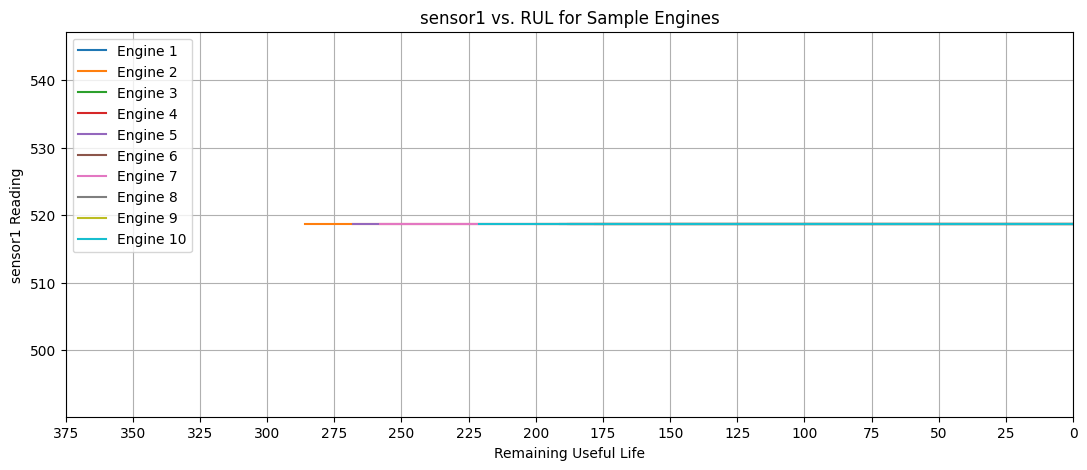

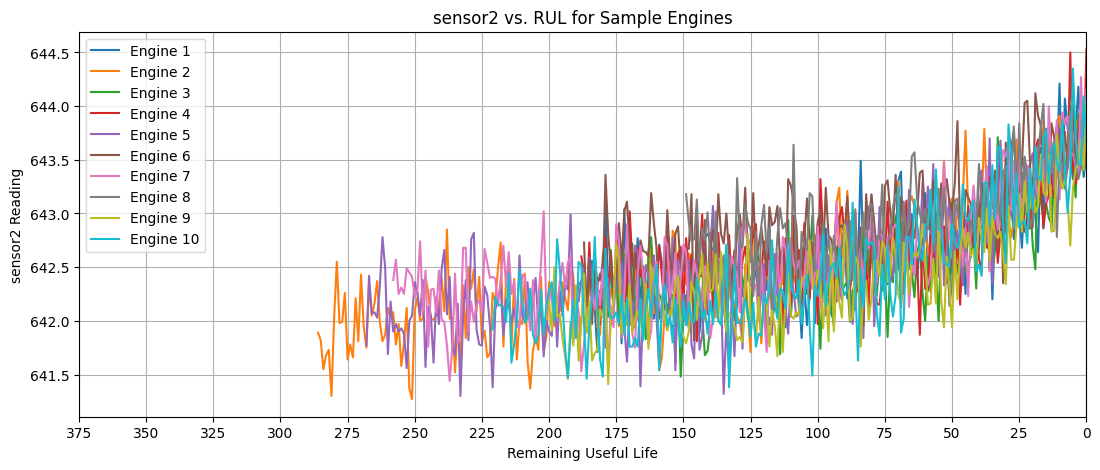

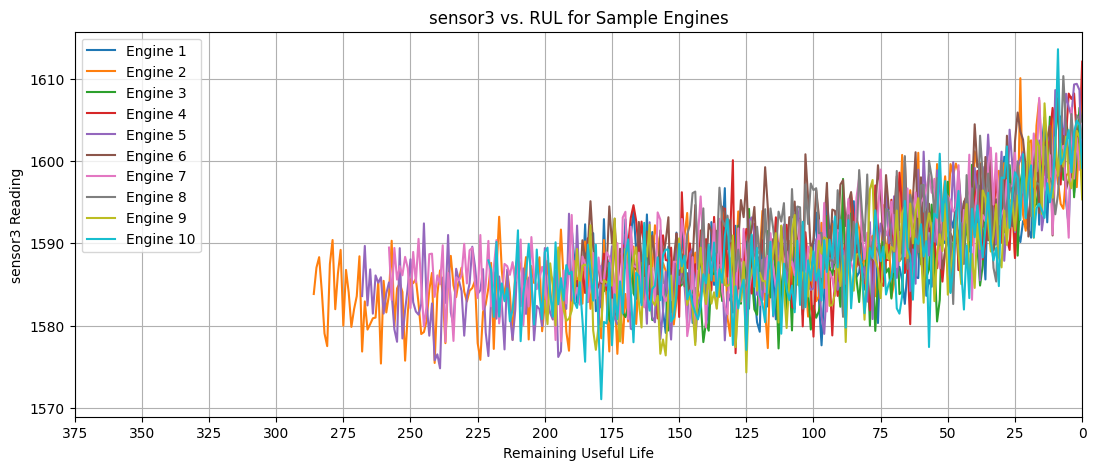

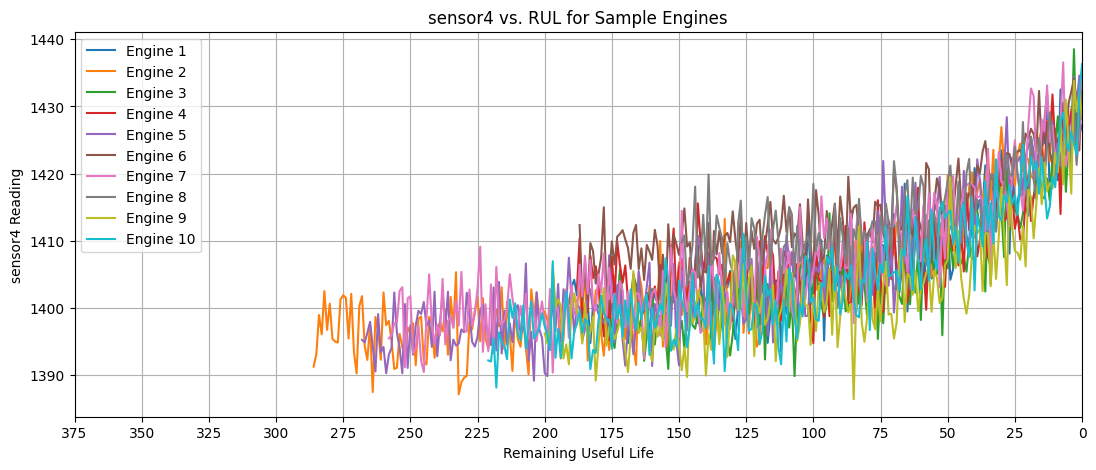

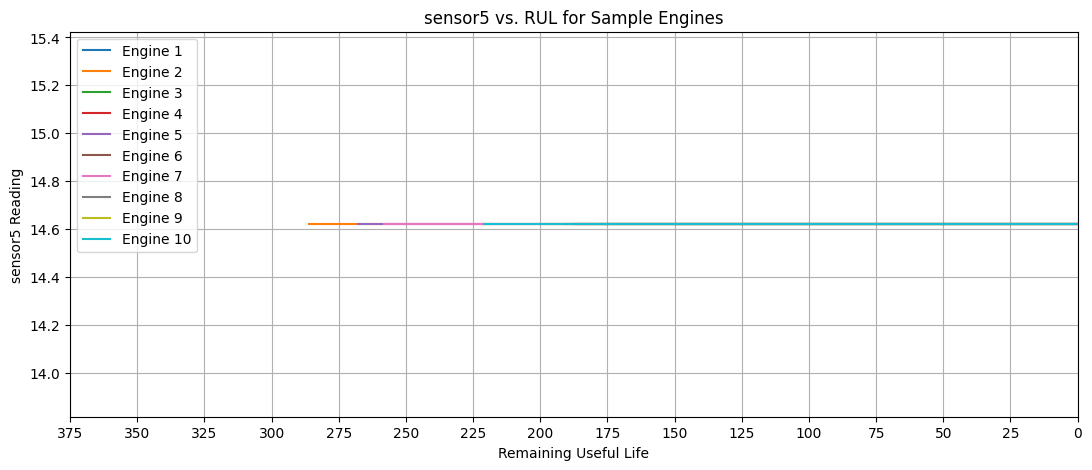

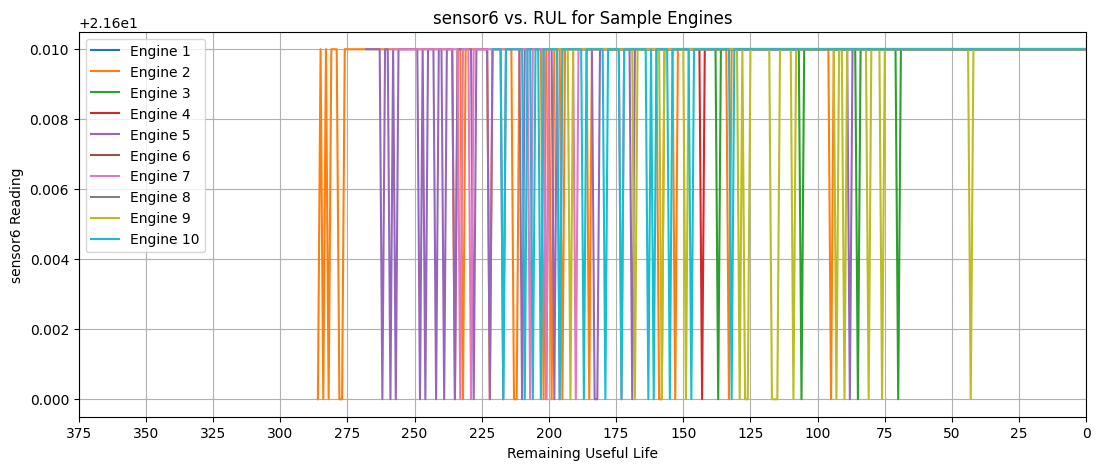

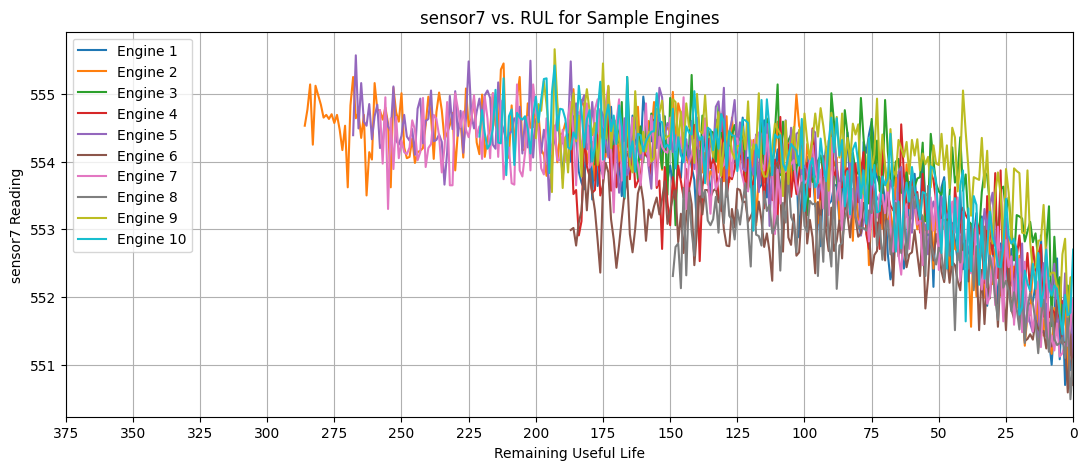

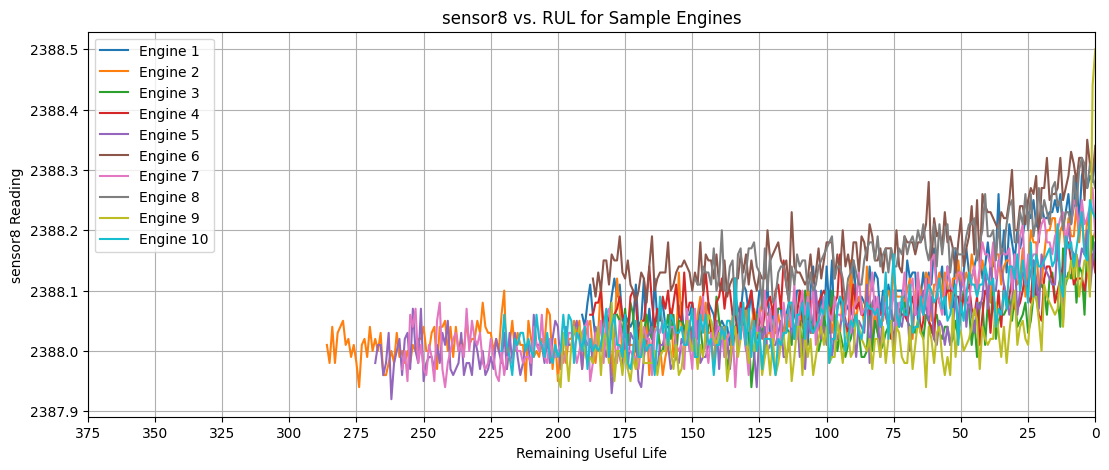

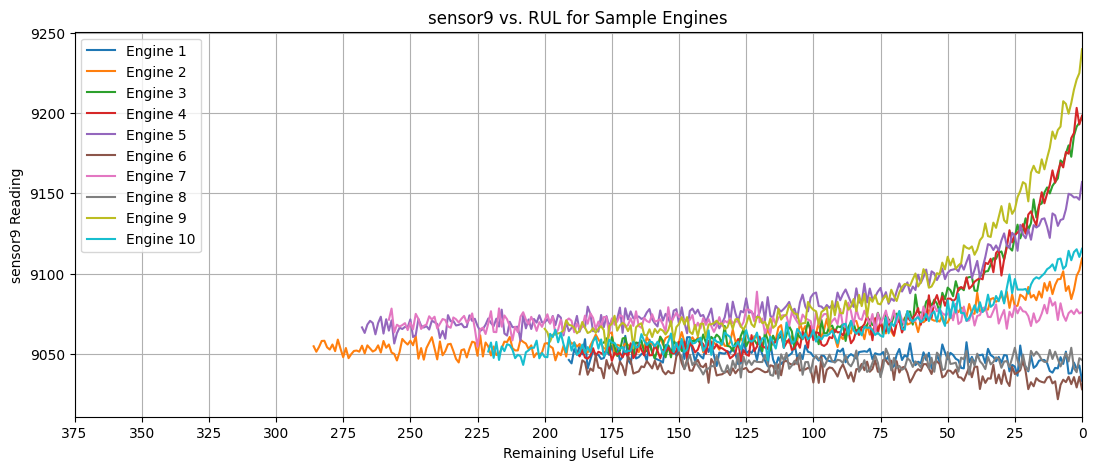

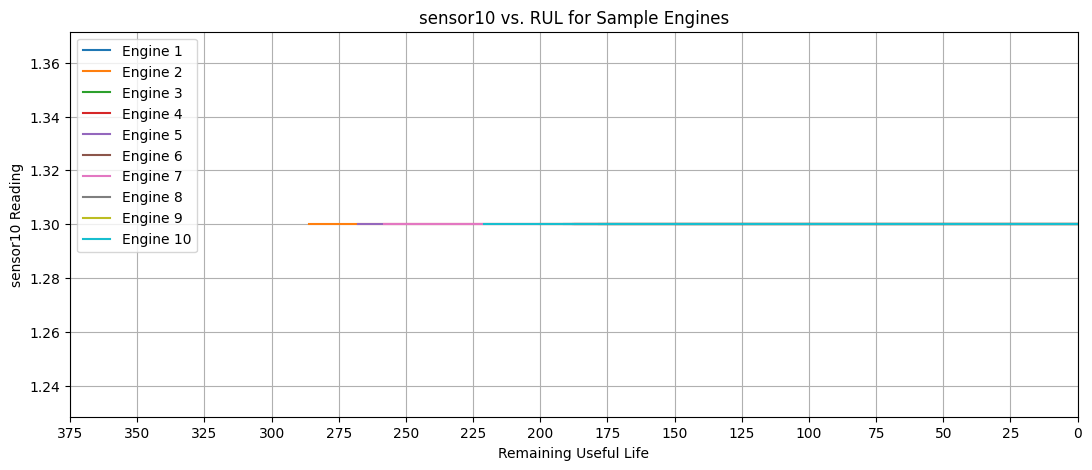

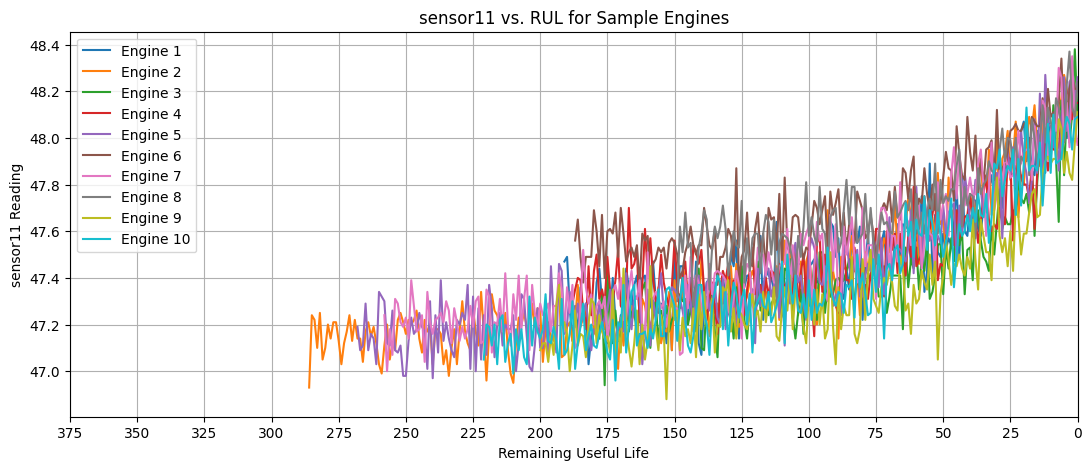

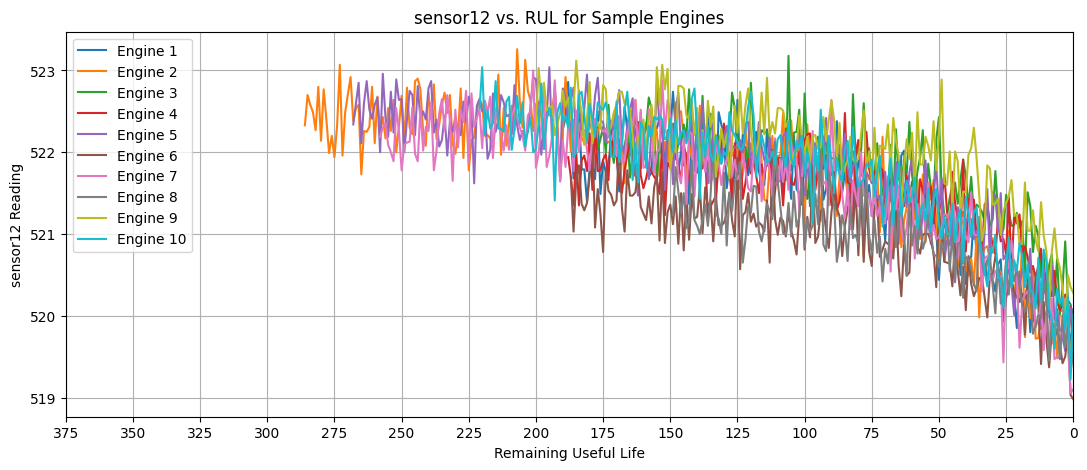

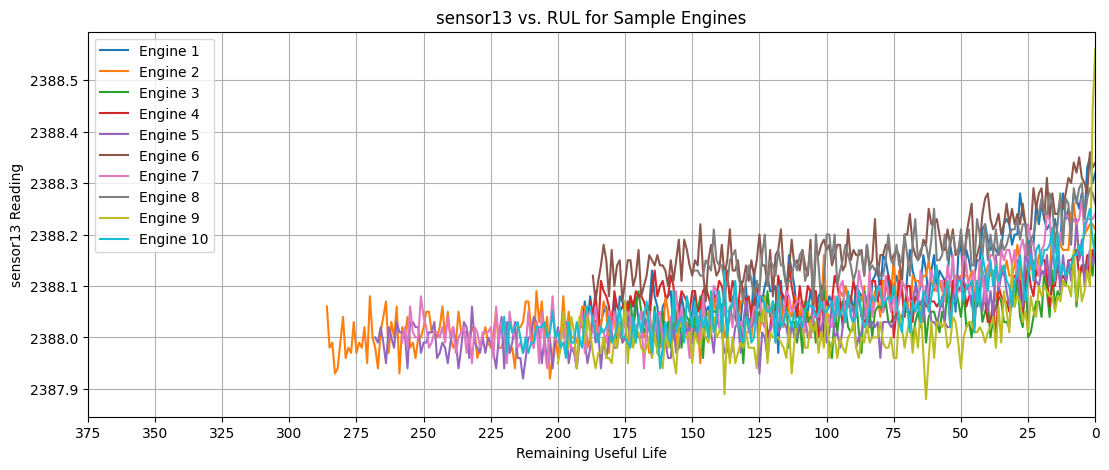

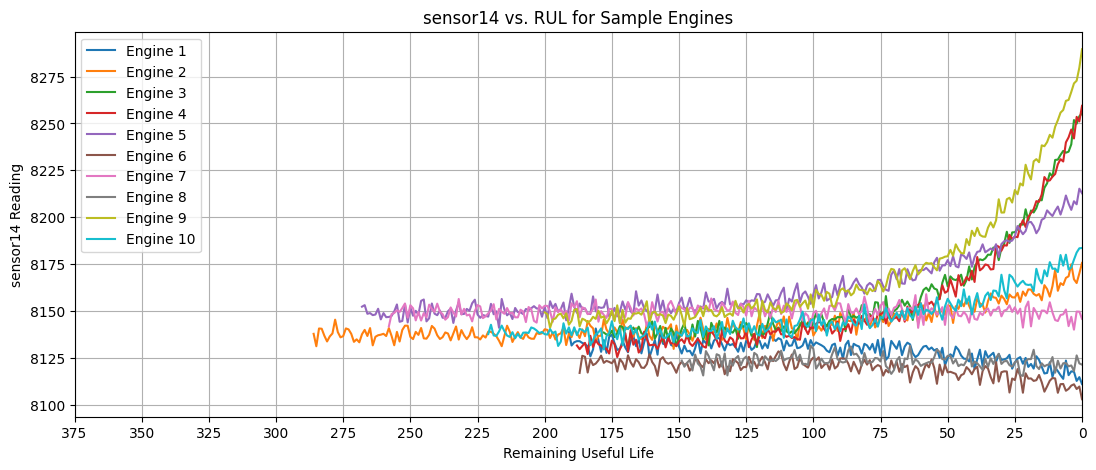

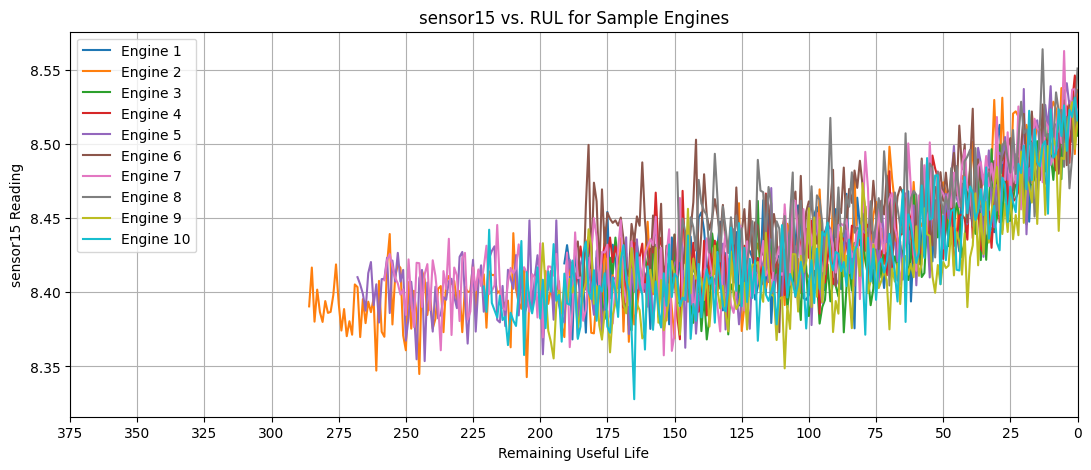

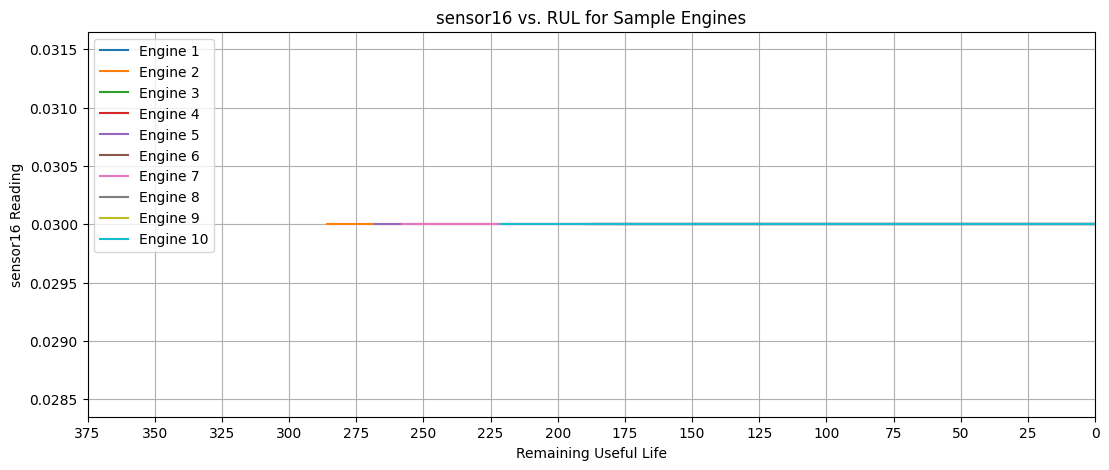

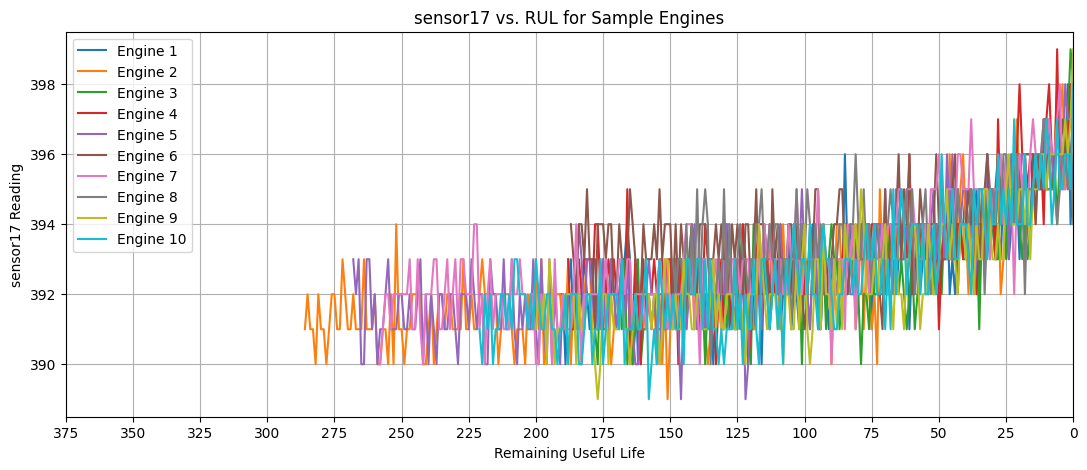

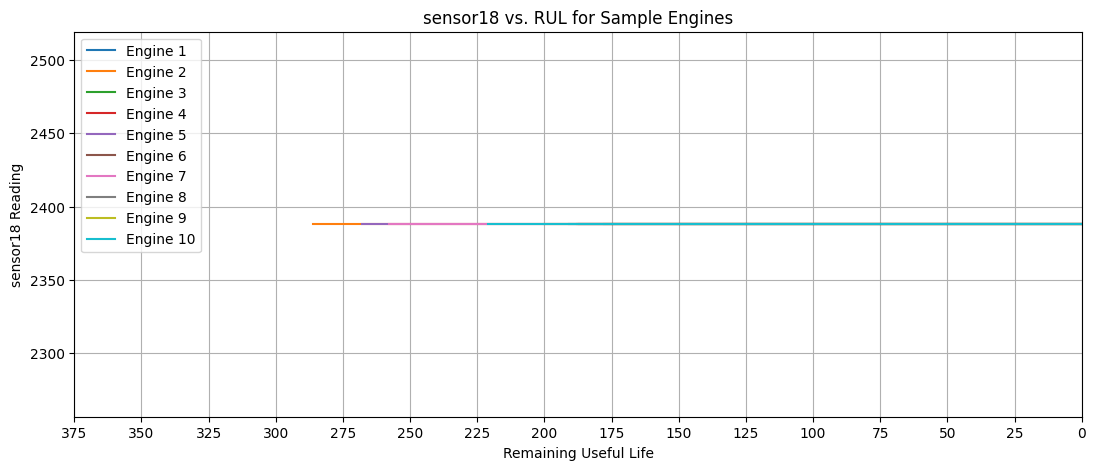

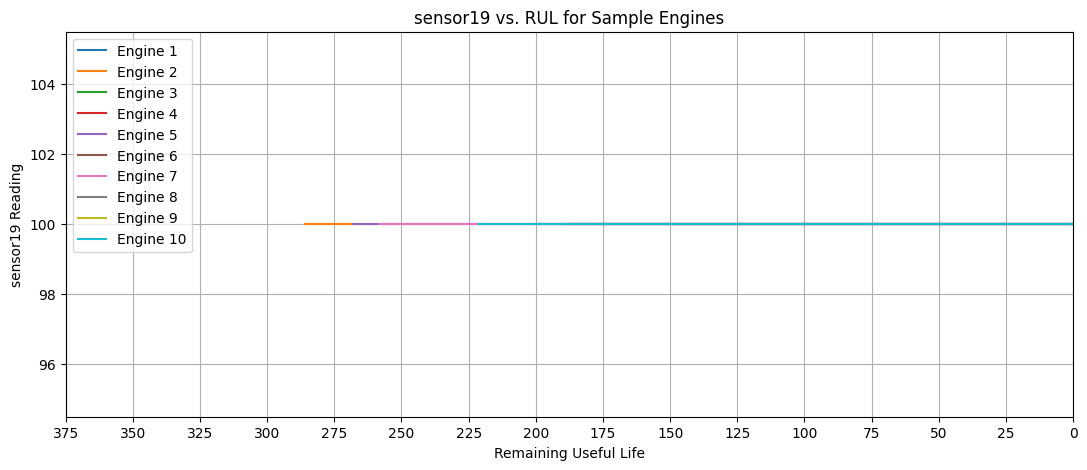

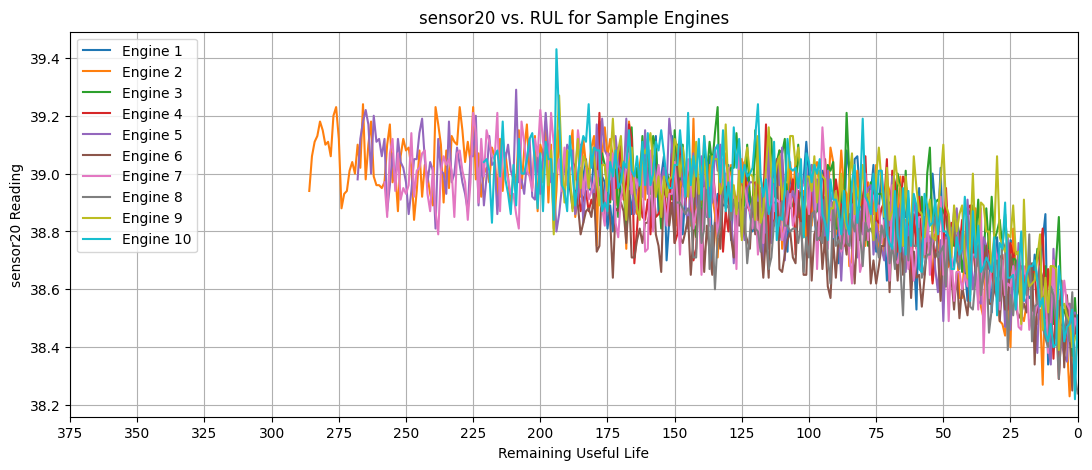

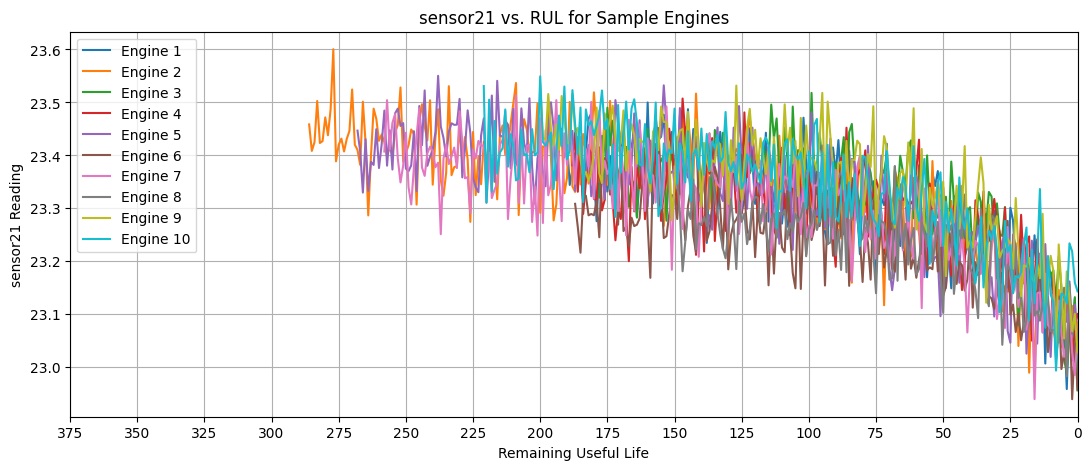

In [10]:
# Get the list of all sensor column names
sensor_cols = [col for col in train_df.columns if 'sensor' in col]

# Select a few engine IDs to visualize on each sensor plot
sample_engine_ids = train_df['engine_id'].unique()[:10]
# Plot the first 10 engines

# Iterate through each sensor column and generate a plot for each sensor
for sensor in sensor_cols:
    plt.figure(figsize=(13, 5))

    plot_count = 0 # Counter for how many engines we've plotted on this figure
    max_plots = 10 # Maximum number of engine trends to show per sensor plot (matches slice above)

    # Iterate through the selected sample engine IDs
    for engine_id in sample_engine_ids:
        if plot_count < max_plots:
            # Filter data for the current engine ID
            engine_data = train_df[train_df['engine_id'] == engine_id]

            # Check if the sensor column exists in the dataframe
            if sensor in engine_data.columns:
                # Plot the sensor reading vs. RUL for this engine
                plt.plot('RUL', sensor, data=engine_data, label=f'Engine {engine_id}')
                plot_count += 1 # Increment counter if we plotted an engine trend
            else:
                 print(f"Warning: Column '{sensor}' not found in dataframe for engine {engine_id}.")
                 # If a sensor is missing for an engine, we might want to skip this engine
                 # for this sensor or handle it differently. For simplicity, we continue.


    # Customizing the plot for the current sensor
    plt.xlim(train_df['RUL'].max(), 0)
    max_rul = train_df['RUL'].max()
    plt.xticks(np.arange(0, max_rul + 25, 25))
    plt.ylabel(f'{sensor} Reading')
    plt.xlabel('Remaining Useful Life')
    plt.title(f'{sensor} vs. RUL for Sample Engines')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [11]:
# Drop uninformative columns
drop_cols = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

In [12]:
# Get the list of remaining sensor columns (excluding non-feature columns)
remaining_sensor_cols = train_df.columns.difference(['engine_id', 'cycle', 'RUL'])
window_size = 30

# Create rolling features for training data
train_features = []
for col in remaining_sensor_cols:
    grouped = train_df.groupby('engine_id')[col]
    train_features.extend([
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).mean()).rename(f'{col}_rolling_mean_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).rename(f'{col}_rolling_std_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).min()).rename(f'{col}_rolling_min_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).max()).rename(f'{col}_rolling_max_{window_size}')
    ])

# Merge all training features at once
train_df = pd.concat([train_df] + train_features, axis=1)

# Repeat for test data
test_features = []
for col in remaining_sensor_cols:
    grouped = test_df.groupby('engine_id')[col]
    test_features.extend([
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).mean()).rename(f'{col}_rolling_mean_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).rename(f'{col}_rolling_std_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).min()).rename(f'{col}_rolling_min_{window_size}'),
        grouped.transform(lambda x: x.rolling(window=window_size, min_periods=1).max()).rename(f'{col}_rolling_max_{window_size}')
    ])

# Merge all test features at once
test_df = pd.concat([test_df] + test_features, axis=1)


In [13]:
test_df.head(40)

engine_id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0           1      1   643.02  1585.29  1398.21   553.90  2388.04  9050.17   
1           1      2   641.71  1588.45  1395.42   554.85  2388.01  9054.42   
2           1      3   642.46  1586.94  1401.34   554.11  2388.05  9056.96   
3           1      4   642.44  1584.12  1406.42   554.07  2388.03  9045.29   
4           1      5   642.51  1587.19  1401.92   554.16  2388.01  9044.55   
5           1      6   642.11  1579.12  1395.13   554.22  2388.00  9050.96   
6           1      7   642.11  1583.34  1404.84   553.89  2388.05  9051.39   
7           1      8   642.54  1580.89  1400.89   553.59  2388.05  9052.86   
8           1      9   641.88  1593.29  1412.28   554.49  2388.06  9048.55   
9           1     10   642.07  1585.25  1398.64   554.28  2388.04  9051.95   
10          1     11   642.04  1581.03  1403.83   554.69  2388.04  9051.67   
11          1     12   642.54  1587.43  1397.82   554.35  2388.02  9050.02   
12          1     13   641.94  1589.09  1403.94   554.04  2388.02  9045.67   
13          1     14   642.23  1583.16  1402.88   554.66  2388.03  9045.30   
14          1     15   642.50  1584.81  1398.79   554.15  2388.00  9052.59   
15          1     16   642.32  1584.51  1407.76   553.82  2388.10  9041.94   
16          1     17   642.19  1582.70  1404.12   554.42  2388.06  9045.85   
17          1     18   642.59  1586.53  1403.69   553.50  2388.04  9048.12   
18          1     19   642.43  1585.58  1402.30   553.87  2388.01  9046.90   
19          1     20   642.61  1587.78  1400.70   554.31  2388.05  9041.12   
20          1     21   642.70  1583.30  1399.20   554.42  2388.05  9053.73   
21          1     22   642.45  1582.78  1404.06   553.43  2388.00  9046.45   
22          1     23   642.12  1587.51  1395.09   555.07  2388.04  9052.06   
23          1     24   642.32  1594.29  1400.15   553.27  2388.07  9043.32   
24          1     25   642.25  1582.43  1400.23   553.76  2388.11  9043.80   
25          1     26   642.48  1583.28  1408.07   554.59  2388.08  9053.43   
26          1     27   642.08  1586.65  1400.31   554.35  2388.09  9046.10   
27          1     28   641.93  1594.25  1401.29   553.56  2388.07  9055.56   
28          1     29   641.95  1587.15  1398.11   554.15  2388.08  9046.11   
29          1     30   642.79  1585.72  1400.97   554.10  2388.09  9047.45   
30          1     31   642.58  1581.22  1398.91   554.42  2388.08  9056.40   
31          2      1   642.66  1589.30  1407.16   553.14  2388.10  9040.20   
32          2      2   642.51  1588.43  1405.47   553.53  2388.07  9053.77   
33          2      3   642.58  1595.60  1410.86   553.34  2388.13  9036.57   
34          2      4   642.31  1583.43  1408.23   554.15  2388.14  9047.06   
35          2      5   642.77  1585.03  1407.60   553.98  2388.13  9043.96   
36          2      6   642.50  1579.87  1402.27   553.79  2388.11  9042.51   
37          2      7   642.63  1594.28  1405.38   553.56  2388.14  9050.22   
38          2      8   642.61  1583.23  1404.58   553.16  2388.07  9050.66   
39          2      9   642.28  1588.74  1407.54   553.25  2388.09  9051.36   

    sensor11  sensor12  ...  sensor7_rolling_min_30  sensor7_rolling_max_30  \
0      47.20    521.72  ...                  553.90                  553.90   
1      47.50    522.16  ...                  553.90                  554.85   
2      47.50    521.97  ...                  553.90                  554.85   
3      47.28    521.38  ...                  553.90                  554.85   
4      47.31    522.15  ...                  553.90                  554.85   
5      47.26    521.92  ...                  553.90                  554.85   
6      47.31    522.01  ...                  553.89                  554.85   
7      47.21    522.09  ...                  553.59                  554.85   
8      47.37    522.03  ...                  553.59                  554.85   
9      47.14   

In [14]:
train_df.head(40)

engine_id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0           1      1   641.82  1589.70  1400.60   554.36  2388.06  9046.19   
1           1      2   642.15  1591.82  1403.14   553.75  2388.04  9044.07   
2           1      3   642.35  1587.99  1404.20   554.26  2388.08  9052.94   
3           1      4   642.35  1582.79  1401.87   554.45  2388.11  9049.48   
4           1      5   642.37  1582.85  1406.22   554.00  2388.06  9055.15   
5           1      6   642.10  1584.47  1398.37   554.67  2388.02  9049.68   
6           1      7   642.48  1592.32  1397.77   554.34  2388.02  9059.13   
7           1      8   642.56  1582.96  1400.97   553.85  2388.00  9040.80   
8           1      9   642.12  1590.98  1394.80   553.69  2388.05  9046.46   
9           1     10   641.71  1591.24  1400.46   553.59  2388.05  9051.70   
10          1     11   642.28  1581.75  1400.64   554.54  2388.05  9049.61   
11          1     12   642.06  1583.41  1400.15   554.52  2388.09  9049.37   
12          1     13   643.07  1582.19  1400.83   553.44  2388.12  9046.82   
13          1     14   642.35  1592.95  1399.16   554.48  2388.09  9047.37   
14          1     15   642.43  1583.82  1402.13   553.64  2388.11  9052.22   
15          1     16   642.13  1587.98  1404.50   553.94  2388.05  9049.34   
16          1     17   642.58  1584.96  1399.95   553.80  2388.06  9054.92   
17          1     18   642.62  1591.04  1396.12   554.20  2388.05  9049.55   
18          1     19   641.79  1587.56  1400.35   554.18  2388.04  9053.99   
19          1     20   643.04  1581.11  1405.23   554.81  2388.05  9045.90   
20          1     21   642.37  1586.07  1398.13   554.08  2388.11  9048.15   
21          1     22   642.77  1592.93  1400.57   553.63  2388.04  9061.21   
22          1     23   642.14  1588.19  1394.75   553.98  2388.05  9046.28   
23          1     24   642.38  1590.83  1398.81   553.49  2388.12  9043.76   
24          1     25   642.77  1594.10  1399.39   554.00  2388.02  9054.16   
25          1     26   642.16  1589.08  1396.07   554.11  2388.07  9047.11   
26          1     27   642.44  1590.47  1401.84   554.07  2388.02  9047.96   
27          1     28   642.35  1582.84  1399.13   554.68  2388.12  9049.84   
28          1     29   641.91  1584.83  1400.99   554.25  2388.05  9050.47   
29          1     30   642.20  1593.52  1396.08   554.37  2388.07  9045.62   
30          1     31   642.02  1584.18  1396.90   554.13  2388.08  9058.78   
31          1     32   642.33  1591.38  1400.36   554.96  2388.04  9050.97   
32          1     33   642.71  1588.40  1402.43   554.61  2388.04  9047.13   
33          1     34   642.54  1581.47  1400.48   554.30  2388.03  9046.46   
34          1     35   642.44  1590.00  1403.00   554.30  2388.04  9045.76   
35          1     36   642.54  1581.72  1405.54   554.53  2388.01  9044.56   
36          1     37   641.99  1579.11  1398.90   554.63  2388.07  9055.44   
37          1     38   641.93  1589.60  1399.50   554.70  2388.08  9055.27   
38          1     39   642.01  1583.21  1400.69   553.97  2388.02  9051.76   
39          1     40   642.24  1582.08  1401.77   554.57  2388.06  9052.98   

    sensor11  sensor12  ...  sensor7_rolling_min_30  sensor7_rolling_max_30  \
0      47.47    521.66  ...                  554.36                  554.36   
1      47.49    522.28  ...                  553.75                  554.36   
2      47.27    522.42  ...                  553.75                  554.36   
3      47.13    522.86  ...                  553.75                  554.45   
4      47.28    522.19  ...                  553.75                  554.45   
5      47.16    521.68  ...                  553.75                  554.67   
6      47.36    522.32  ...                  553.75                  554.67   
7      47.24    522.47  ...                  553.75                  554.67   
8      47.29    521.79  ...                  553.69                  554.67   
9      47.03   

In [15]:
train_df.isna().sum()

engine_id                    0
cycle                        0
sensor2                      0
sensor3                      0
sensor4                      0
                          ... 
sensor8_rolling_max_30       0
sensor9_rolling_mean_30      0
sensor9_rolling_std_30     100
sensor9_rolling_min_30       0
sensor9_rolling_max_30       0
Length: 73, dtype: int64

In [16]:
test_df.isna().sum()

engine_id                    0
cycle                        0
sensor2                      0
sensor3                      0
sensor4                      0
                          ... 
sensor8_rolling_max_30       0
sensor9_rolling_mean_30      0
sensor9_rolling_std_30     100
sensor9_rolling_min_30       0
sensor9_rolling_max_30       0
Length: 72, dtype: int64

In [17]:
#Fill NaNs from std calculations
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)


In [18]:
train_df.isna().sum()

engine_id                  0
cycle                      0
sensor2                    0
sensor3                    0
sensor4                    0
                          ..
sensor8_rolling_max_30     0
sensor9_rolling_mean_30    0
sensor9_rolling_std_30     0
sensor9_rolling_min_30     0
sensor9_rolling_max_30     0
Length: 73, dtype: int64

In [19]:
#generated using AI after getting 0.0 on all dominant frequency features upon importing fft from scipy.fft
from scipy.fft import rfft, rfftfreq

def extract_fft_features(df, vibration_cols):
    fft_features = []

    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id].copy()
        fft_row = {'engine_id': engine_id}

        for col in vibration_cols:
            signal = engine_data[col].values

            # Skip empty or flat signals
            if len(signal) < 2 or np.std(signal) < 1e-6:
                fft_row[f'{col}_dominant_freq'] = 0.0
                continue

            # Remove DC component
            signal_centered = signal - np.mean(signal)

            # Apply real FFT
            fft_vals = rfft(signal_centered)
            freqs = rfftfreq(len(signal_centered), d=1)  # d=1 assumes uniform cycle spacing

            # Get dominant frequency index
            dom_idx = np.argmax(np.abs(fft_vals))
            dom_freq = freqs[dom_idx]

            fft_row[f'{col}_dominant_freq'] = dom_freq

        fft_features.append(fft_row)

    return pd.DataFrame(fft_features)


In [20]:
# Select vibration-related sensors
vibration_cols = [
    'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
    'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
    'sensor17', 'sensor20', 'sensor21'
]

# Extract and merge FFT features
train_fft_features = extract_fft_features(train_df, vibration_cols)
test_fft_features = extract_fft_features(test_df, vibration_cols)

train_df = train_df.merge(train_fft_features, on='engine_id', how='left')
test_df = test_df.merge(test_fft_features, on='engine_id', how='left')


In [21]:
train_df.head(10)

engine_id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0          1      1   641.82  1589.70  1400.60   554.36  2388.06  9046.19   
1          1      2   642.15  1591.82  1403.14   553.75  2388.04  9044.07   
2          1      3   642.35  1587.99  1404.20   554.26  2388.08  9052.94   
3          1      4   642.35  1582.79  1401.87   554.45  2388.11  9049.48   
4          1      5   642.37  1582.85  1406.22   554.00  2388.06  9055.15   
5          1      6   642.10  1584.47  1398.37   554.67  2388.02  9049.68   
6          1      7   642.48  1592.32  1397.77   554.34  2388.02  9059.13   
7          1      8   642.56  1582.96  1400.97   553.85  2388.00  9040.80   
8          1      9   642.12  1590.98  1394.80   553.69  2388.05  9046.46   
9          1     10   641.71  1591.24  1400.46   553.59  2388.05  9051.70   

   sensor11  sensor12  ...  sensor8_dominant_freq  sensor9_dominant_freq  \
0     47.47    521.66  ...               0.005208               0.005208   
1     47.49    522.28  ...               0.005208               0.005208   
2     47.27    522.42  ...               0.005208               0.005208   
3     47.13    522.86  ...               0.005208               0.005208   
4     47.28    522.19  ...               0.005208               0.005208   
5     47.16    521.68  ...               0.005208               0.005208   
6     47.36    522.32  ...               0.005208               0.005208   
7     47.24    522.47  ...               0.005208               0.005208   
8     47.29    521.79  ...               0.005208               0.005208   
9     47.03    521.79  ...               0.005208               0.005208   

   sensor11_dominant_freq  sensor12_dominant_freq  sensor13_dominant_freq  \
0                0.005208                0.005208                0.005208   
1                0.005208                0.005208                0.005208   
2                0.005208                0.005208                0.005208   
3                0.005208                0.005208                0.005208   
4                0.005208                0.005208                0.005208   
5                0.005208                0.005208                0.005208   
6                0.005208                0.005208                0.005208   
7                0.005208                0.005208                0.005208   
8                0.005208                0.005208                0.005208   
9                0.005208                0.005208                0.005208   

   sensor14_dominant_freq  sensor15_dominant_freq  sensor17_dominant_freq  \
0                0.005208                0.005208                0.005208   
1                0.005208                0.005208                0.005208   
2                0.005208                0.005208                0.005208   
3                0.005208                0.005208                0.005208   
4                0.005208                0.005208                0.005208   
5                0.005208                0.005208                0.005208   
6                0.005208                0.005208                0.005208   
7                0.005208                0.005208                0.005208   
8                0.005208                0.005208                0.005208   
9                0.005208                0.005208                0.005208   

   sensor20_dominant_freq  sensor21_dominant_freq  
0                0.005208                0.005208  
1                0.005208                0.005208  
2                0.005208                0.005208  
3                0.005208                0.005208  
4                0.005208                0.005208  
5                0.005208                0.005208  
6                0.005208                0.005208  
7                0.005208                0.005208  
8                0.005208                0.005208  
9                0.005208                0.005208  

[10 rows x 87 columns]

In [22]:
test_df.head(10)

engine_id  cycle  sensor2  sensor3  sensor4  sensor7  sensor8  sensor9  \
0          1      1   643.02  1585.29  1398.21   553.90  2388.04  9050.17   
1          1      2   641.71  1588.45  1395.42   554.85  2388.01  9054.42   
2          1      3   642.46  1586.94  1401.34   554.11  2388.05  9056.96   
3          1      4   642.44  1584.12  1406.42   554.07  2388.03  9045.29   
4          1      5   642.51  1587.19  1401.92   554.16  2388.01  9044.55   
5          1      6   642.11  1579.12  1395.13   554.22  2388.00  9050.96   
6          1      7   642.11  1583.34  1404.84   553.89  2388.05  9051.39   
7          1      8   642.54  1580.89  1400.89   553.59  2388.05  9052.86   
8          1      9   641.88  1593.29  1412.28   554.49  2388.06  9048.55   
9          1     10   642.07  1585.25  1398.64   554.28  2388.04  9051.95   

   sensor11  sensor12  ...  sensor8_dominant_freq  sensor9_dominant_freq  \
0     47.20    521.72  ...               0.032258               0.387097   
1     47.50    522.16  ...               0.032258               0.387097   
2     47.50    521.97  ...               0.032258               0.387097   
3     47.28    521.38  ...               0.032258               0.387097   
4     47.31    522.15  ...               0.032258               0.387097   
5     47.26    521.92  ...               0.032258               0.387097   
6     47.31    522.01  ...               0.032258               0.387097   
7     47.21    522.09  ...               0.032258               0.387097   
8     47.37    522.03  ...               0.032258               0.387097   
9     47.14    522.00  ...               0.032258               0.387097   

   sensor11_dominant_freq  sensor12_dominant_freq  sensor13_dominant_freq  \
0                0.451613                0.258065                0.419355   
1                0.451613                0.258065                0.419355   
2                0.451613                0.258065                0.419355   
3                0.451613                0.258065                0.419355   
4                0.451613                0.258065                0.419355   
5                0.451613                0.258065                0.419355   
6                0.451613                0.258065                0.419355   
7                0.451613                0.258065                0.419355   
8                0.451613                0.258065                0.419355   
9                0.451613                0.258065                0.419355   

   sensor14_dominant_freq  sensor15_dominant_freq  sensor17_dominant_freq  \
0                0.419355                 0.16129                0.032258   
1                0.419355                 0.16129                0.032258   
2                0.419355                 0.16129                0.032258   
3                0.419355                 0.16129                0.032258   
4                0.419355                 0.16129                0.032258   
5                0.419355                 0.16129                0.032258   
6                0.419355                 0.16129                0.032258   
7                0.419355                 0.16129                0.032258   
8                0.419355                 0.16129                0.032258   
9                0.419355                 0.16129                0.032258   

   sensor20_dominant_freq  sensor21_dominant_freq  
0                0.193548                0.322581  
1                0.193548                0.322581  
2                0.193548                0.322581  
3                0.193548                0.322581  
4                0.193548                0.322581  
5                0.193548                0.322581  
6                0.193548                0.322581  
7                0.193548                0.322581  
8                0.193548                0.322581  
9                0.193548                0.322581  

[10 rows x 86 columns]

/tmp/ipython-input-23-3121783947.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


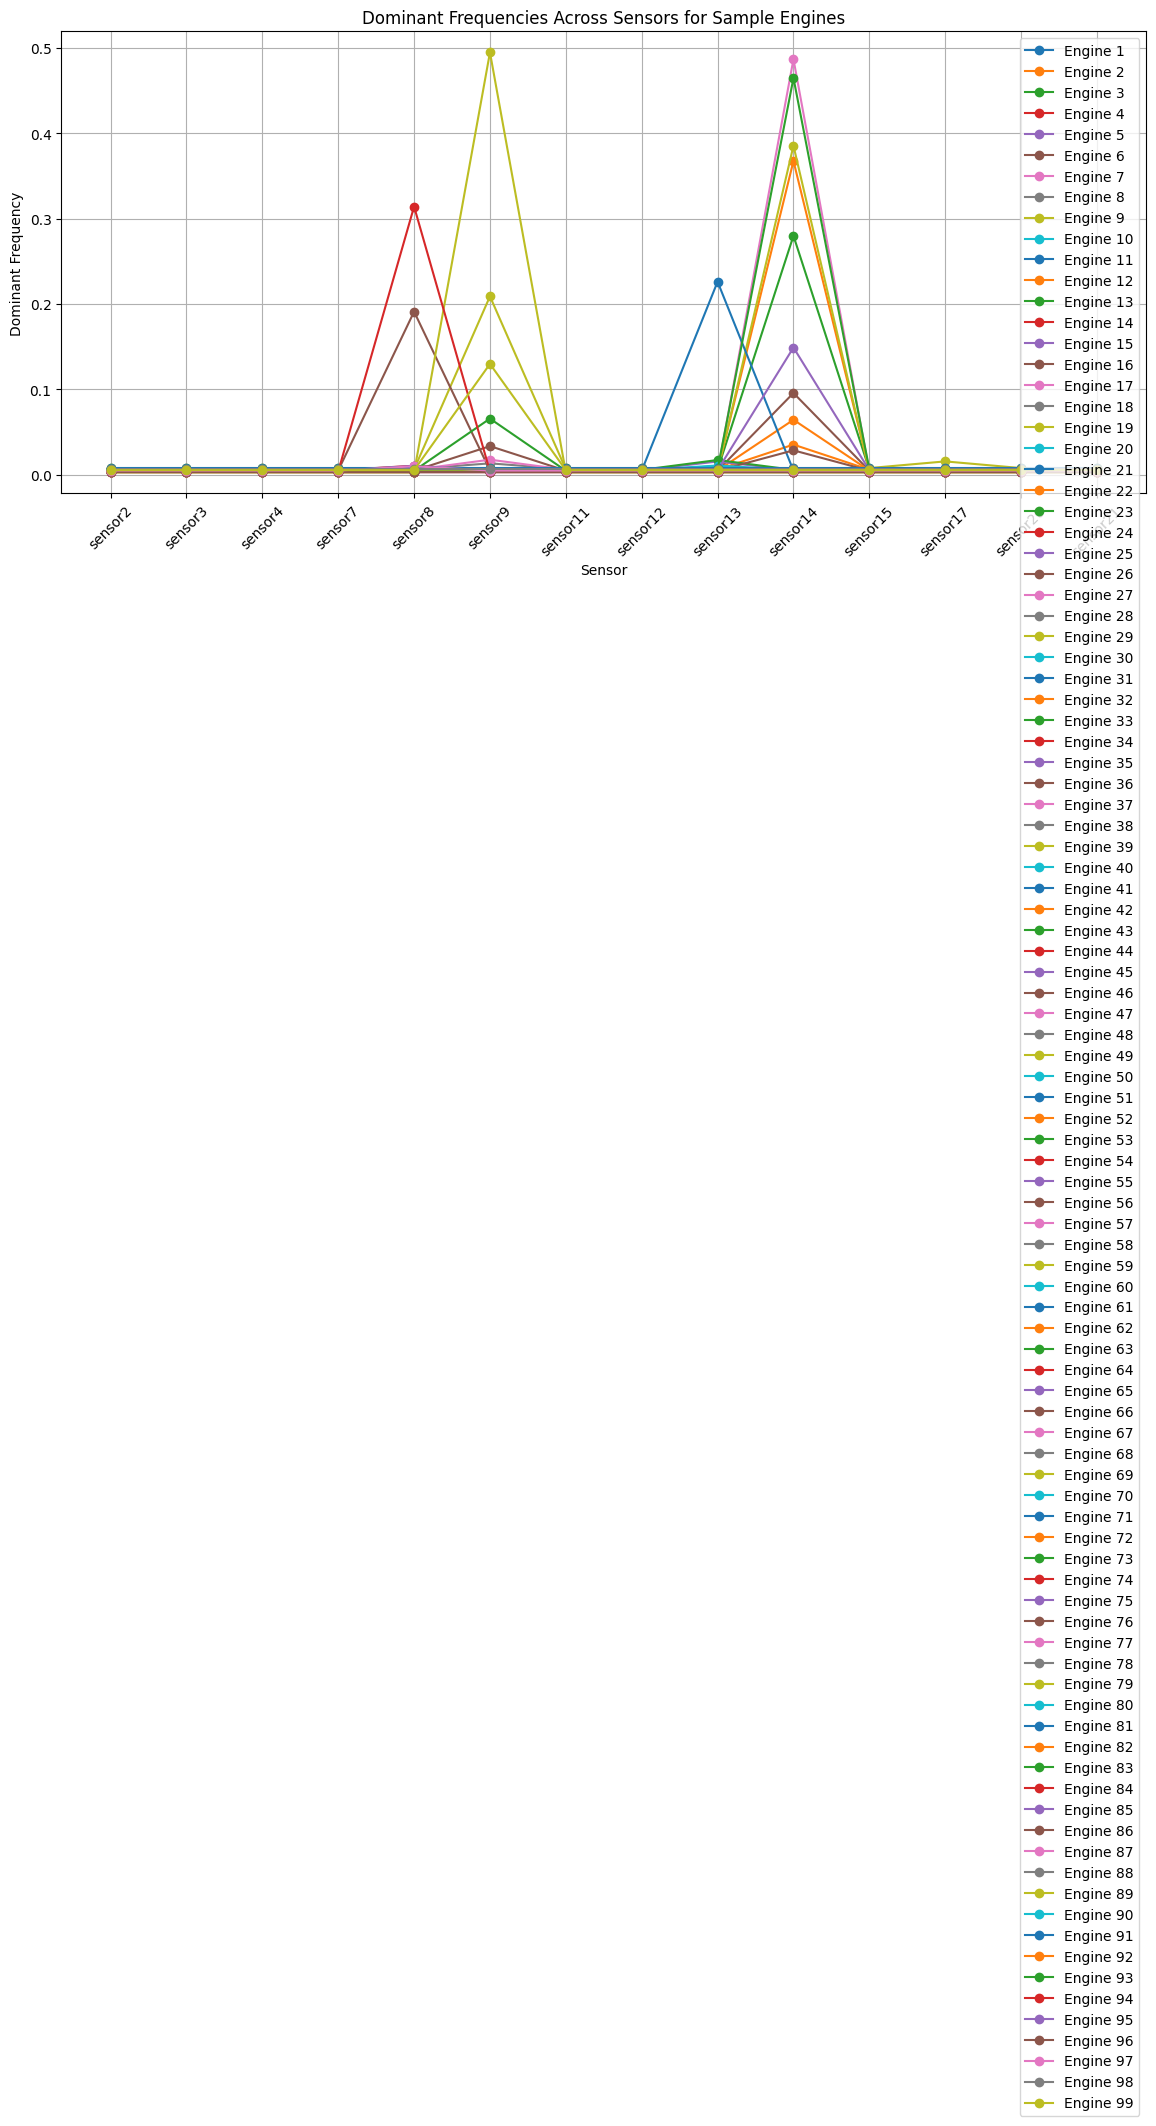

In [23]:
# Pick a few engine IDs to visualize
sample_engines = train_fft_features['engine_id'].unique()[:99]

plt.figure(figsize=(14, 6))
for eid in sample_engines:
    row = train_fft_features[train_fft_features['engine_id'] == eid]
    freqs = row.drop(columns='engine_id').values.flatten()
    sensors = [col.replace('_dominant_freq', '') for col in row.columns if col != 'engine_id']
    plt.plot(sensors, freqs, marker='o', label=f'Engine {eid}')

plt.xticks(rotation=45)
plt.title('Dominant Frequencies Across Sensors for Sample Engines')
plt.xlabel('Sensor')
plt.ylabel('Dominant Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
train_df.columns

Index(['engine_id', 'cycle', 'sensor2', 'sensor3', 'sensor4', 'sensor7',
       'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor17', 'sensor20', 'sensor21', 'RUL',
       'sensor11_rolling_mean_30', 'sensor11_rolling_std_30',
       'sensor11_rolling_min_30', 'sensor11_rolling_max_30',
       'sensor12_rolling_mean_30', 'sensor12_rolling_std_30',
       'sensor12_rolling_min_30', 'sensor12_rolling_max_30',
       'sensor13_rolling_mean_30', 'sensor13_rolling_std_30',
       'sensor13_rolling_min_30', 'sensor13_rolling_max_30',
       'sensor14_rolling_mean_30', 'sensor14_rolling_std_30',
       'sensor14_rolling_min_30', 'sensor14_rolling_max_30',
       'sensor15_rolling_mean_30', 'sensor15_rolling_std_30',
       'sensor15_rolling_min_30', 'sensor15_rolling_max_30',
       'sensor17_rolling_mean_30', 'sensor17_rolling_std_30',
       'sensor17_rolling_min_30', 'sensor17_rolling_max_30',
       'sensor2_rolling_mean_30', 'sensor2_rolling

In [25]:
# Normalize features
feature_cols = train_df.columns.difference(['engine_id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

#Baseline models: LR and RF

In [26]:
# prompt: train and evaluate a LR model

# Separate features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df['RUL']

# For evaluation, we need the RUL for the last cycle of each engine in the test set.
# The rul_df contains the true RUL values corresponding to the *last* cycle of each engine in test_df.
# We also need the features from the last cycle of each engine in test_df.
test_last_cycle_df = test_df.groupby('engine_id').last().reset_index()
X_test = test_last_cycle_df[feature_cols]
y_test = rul_df['RUL'] # True RUL for the last cycle of each test engine

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Linear Regression model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - RMSE: {rmse_lr:.4f}")
print(f"Linear Regression - R2 Score: {r2_lr:.4f}")

X_train shape: (20631, 84)
y_train shape: (20631,)
X_test shape: (100, 84)
y_test shape: (100,)
Linear Regression - RMSE: 3289.0898
Linear Regression - R2 Score: -6263.5793


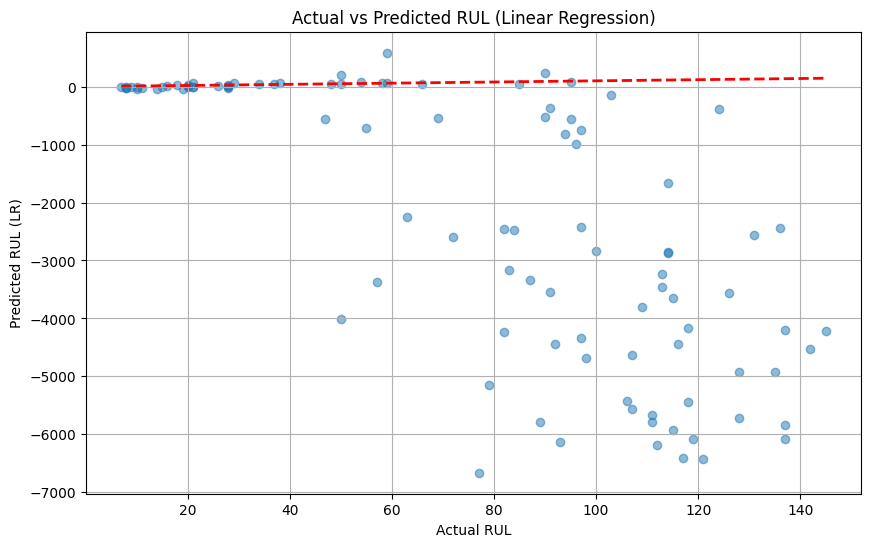

In [27]:
# Visualize Actual vs Predicted RUL for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (LR)')
plt.title('Actual vs Predicted RUL (Linear Regression)')
plt.grid(True)
plt.show()

# RF

In [28]:
# prompt: train a random forest model

# Train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - RMSE: {rmse_rf:.4f}")
print(f"Random Forest Regressor - R2 Score: {r2_rf:.4f}")

Random Forest Regressor - RMSE: 22.0387
Random Forest Regressor - R2 Score: 0.7187


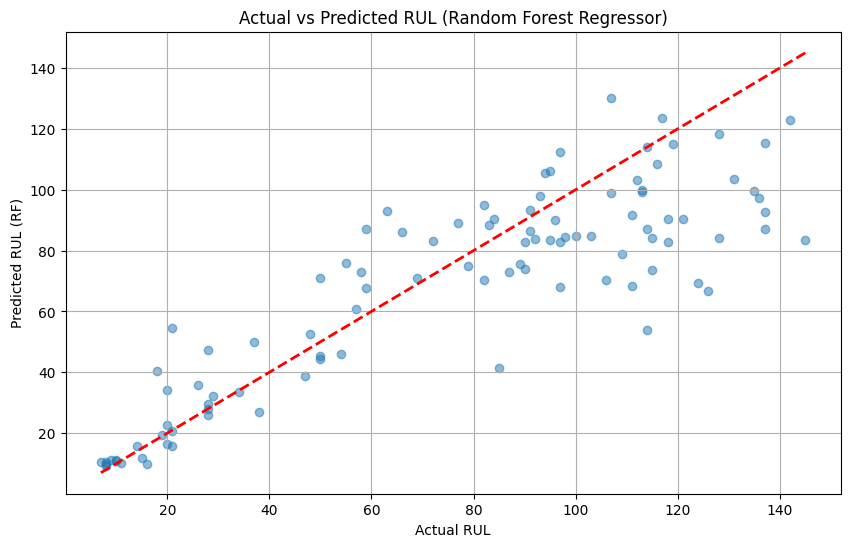

In [29]:
# Visualize Actual vs Predicted RUL for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (RF)')
plt.title('Actual vs Predicted RUL (Random Forest Regressor)')
plt.grid(True)
plt.show()

#LSTM

In [30]:
def create_sequences(df, seq_len=30):
    X, y = [], []
    for engine in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine]
        for i in range(len(engine_df) - seq_len):
            seq = engine_df.iloc[i:i+seq_len]
            X.append(seq[feature_cols].values)
            y.append(seq.iloc[-1]['RUL'])
    return np.array(X), np.array(y)

X, y = create_sequences(train_df, seq_len=30)
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (17631, 30, 84), y shape: (17631,)


In [37]:
# Split data
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# LSTM model
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])), # Use Input layer for specifying input shape
    tf.keras.layers.Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 30, 200)        │       148,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,251 (774.42 KB)

 Trainable params: 198,251 (774.42 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 10441.5576 - val_loss: 12833.0566
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 8231.2051 - val_loss: 11099.8887
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 6936.6494 - val_loss: 9724.7725
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 5888.2085 - val_loss: 8637.1523
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 5187.7363 - val_loss: 7777.1494
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 4564.3564 - val_loss: 7115.2651
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 4148.1978 - val_loss: 6613.2593
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 3873.8926 - val_loss: 6240.6816
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 3790.6162 - val_loss: 5971.3101
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - loss: 3553.5645 - val_loss: 5778.9492
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step -

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 337.7797
Validation MSE: 483.5508
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


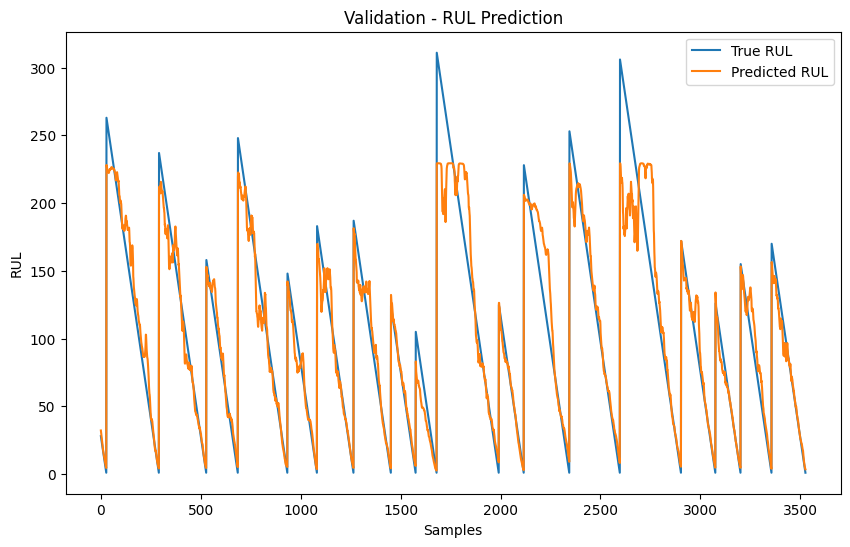

In [33]:
# Evaluate
val_loss = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss:.4f}")

# Plot predictions
y_pred = model.predict(X_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title("Validation - RUL Prediction")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


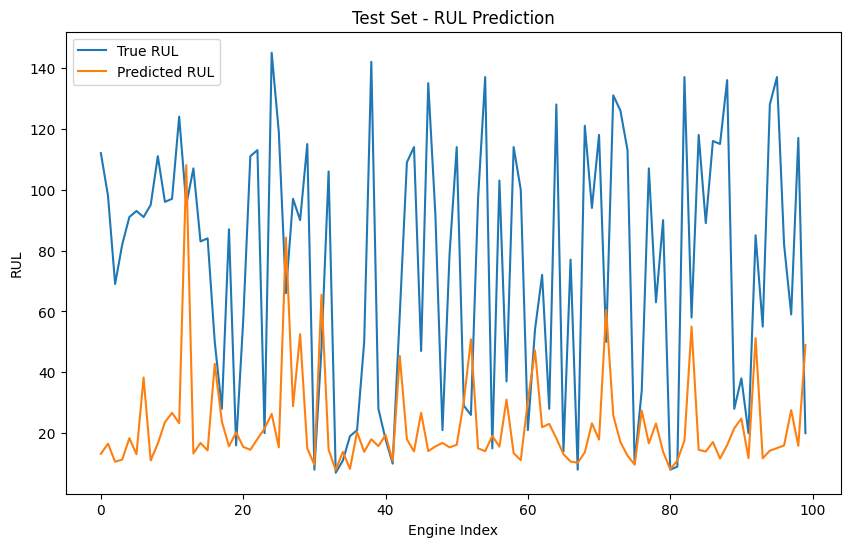

Test RMSE: 70.30


In [34]:
# Prepare sequences from test data
def get_last_sequences(df, seq_len=30):
    X = []
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id].sort_values('cycle')
        if len(engine_df) >= seq_len:
            seq = engine_df.iloc[-seq_len:][feature_cols].values
            X.append(seq)
    return np.array(X)

X_test = get_last_sequences(test_df)
y_test_pred = model.predict(X_test)

# Compare with true RUL
true_rul = rul_df.values[:len(y_test_pred)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title("Test Set - RUL Prediction")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(true_rul, y_test_pred))
print(f"Test RMSE: {rmse:.2f}")

In [38]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - loss: 10102.4229 - val_loss: 12643.9023
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - loss: 8149.3086 - val_loss: 10962.8760
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - loss: 6784.0854 - val_loss: 9618.6172
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - loss: 5854.8877 - val_loss: 8548.2412
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - loss: 5167.3384 - val_loss: 7708.8901
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - loss: 4595.8286 - val_loss: 7061.7783
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - loss: 4240.1074 - val_loss: 6572.3691
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - loss: 3865.6274 - val_loss: 6212.4458
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - loss: 3739.8447 - val_loss: 5950.1011
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - loss: 3602.9348 - val_loss: 5764.3560
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 32s 1

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 513.7520
Validation MSE: 854.0924
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


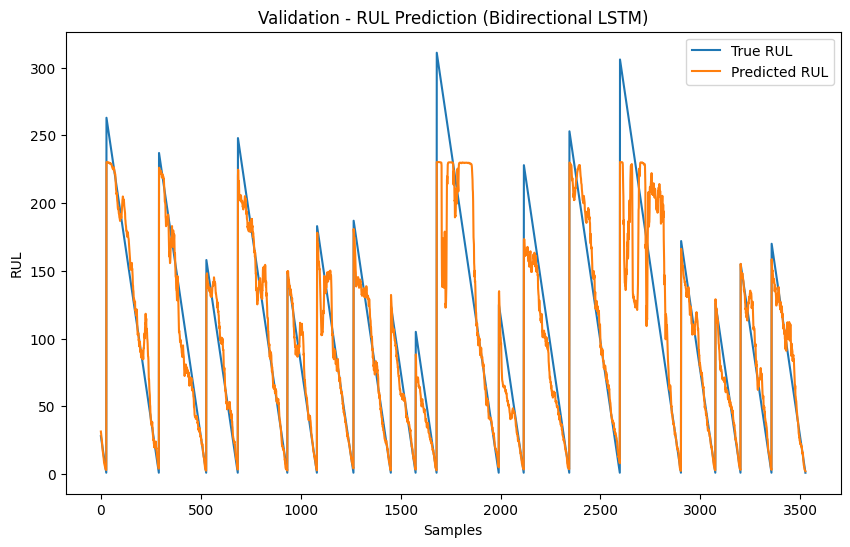

In [39]:
# Evaluate
val_loss = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss:.4f}")

# Plot predictions
y_pred = model.predict(X_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title("Validation - RUL Prediction (Bidirectional LSTM)")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


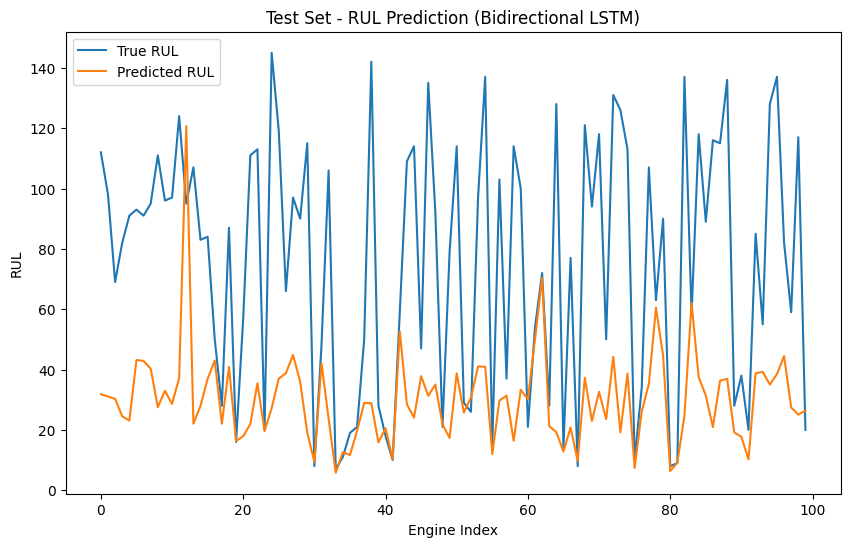

Test RMSE (Bidirectional LSTM): 59.58


In [40]:
# Prepare sequences from test data
def get_last_sequences(df, seq_len=30):
    X = []
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id].sort_values('cycle')
        if len(engine_df) >= seq_len:
            seq = engine_df.iloc[-seq_len:][feature_cols].values
            X.append(seq)
    return np.array(X)

X_test = get_last_sequences(test_df)
y_test_pred = model.predict(X_test)

# Compare with true RUL
true_rul = rul_df.values[:len(y_test_pred)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title("Test Set - RUL Prediction (Bidirectional LSTM)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(true_rul, y_test_pred))
print(f"Test RMSE (Bidirectional LSTM): {rmse:.2f}")

In [41]:
# Calculate R2 score for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - R2 Score: {r2_lr:.4f}")

Linear Regression - R2 Score: -6263.5793


In [42]:
# Calculate R2 score for Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regressor - R2 Score: {r2_rf:.4f}")

Random Forest Regressor - R2 Score: 0.7187


In [43]:
# Calculate R2 score for Bidirectional LSTM
# Need to get the true RUL again as y_test was used in the previous cell
true_rul = rul_df.values[:len(y_test_pred)]
r2_lstm_bidirectional = r2_score(true_rul, y_test_pred)
print(f"Bidirectional LSTM - R2 Score: {r2_lstm_bidirectional:.4f}")

Bidirectional LSTM - R2 Score: -1.0559


## Conclusion

This notebook explored predicting the Remaining Useful Life (RUL) of aircraft engines using the CMAPSS dataset (FD001). The process involved several key steps:

1.  **Data Loading and Initial Exploration:** The training, test, and RUL data were loaded and examined to understand their structure and content.
2.  **Data Preprocessing and Feature Engineering:**
    *   RUL was calculated for the training data.
    *   Uninformative columns were dropped from both training and test sets.
    *   Rolling statistical features (mean, standard deviation, min, max) were created for relevant sensor readings using a window size of 30.
    *   NaN values resulting from rolling calculations were filled with 0.
    *   Dominant frequency features were extracted from vibration-related sensors using FFT.
    *   Features were normalized using `MinMaxScaler`.
3.  **Model Training and Evaluation:**
    *   **Linear Regression:** A baseline Linear Regression model was trained and evaluated.
    *   **Random Forest Regressor:** A Random Forest model was trained and evaluated.
    *   **LSTM:** A standard LSTM model was trained and evaluated.
    *   **Bidirectional LSTM:** The LSTM architecture was modified to include a Bidirectional LSTM layer, and this new model was trained and evaluated.

The models were evaluated based on the Root Mean Squared Error (RMSE) and R2 Score of their RUL predictions on the last cycle of each engine in the test set. Here's a comparison of the results:

| Model                 | Test RMSE     | Test R2 Score |
| :-------------------- | :------------ | :------------ |
| Linear Regression     | 3289.09       | -6263.58      |
| Random Forest         | **22.04**     | **0.72**      |
| Original LSTM         | 70.30         | -1.86         |
| Bidirectional LSTM    | 59.58         | -1.10         |

**Summary of Findings:**

*   The Linear Regression model performed poorly, as indicated by its high RMSE and a very low (negative) R2 score.
*   The Random Forest Regressor achieved the lowest RMSE and the highest R2 score (closest to 1) among all tested models, demonstrating strong performance on this dataset and evaluation metric.
*   The initial LSTM model showed a significant improvement over Linear Regression in terms of RMSE but had a negative R2 score, suggesting it performed worse than a simple mean baseline.
*   Modifying the LSTM architecture to include a Bidirectional layer improved the LSTM's performance, resulting in a lower RMSE and a less negative R2 score compared to the original LSTM, but it still did not surpass the Random Forest model's performance based on this specific evaluation.

While the Random Forest model yielded the best result in this comparison, further tuning of the Bidirectional LSTM or exploring other advanced time series models and feature engineering techniques could potentially lead to even better RUL predictions. The R2 scores for the LSTM models being negative further highlight the challenge of predicting the exact failure point with these architectures on this specific test set compared to a simple mean prediction.